In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import calendar
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectFromModel

pd.options.display.max_columns = None
pd.options.display.max_rows = None

warnings.filterwarnings('ignore')

os.chdir("E:/Trinity/Dissertation/Sem 3/models/data/")

Read the new DataFrame

In [2]:
os.chdir("E:/Trinity/Dissertation/Sem 3/models/")
df = pd.read_csv("HourlyDetails (Boosted).csv")  

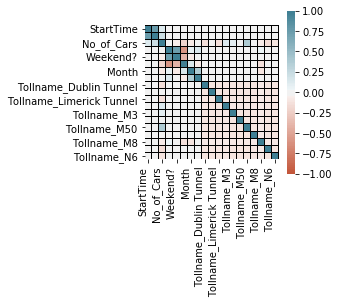

In [3]:
plt.figure(figsize=(3,3))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    linewidths=0.01, 
    linecolor='black',
    #annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [4]:
print(len(df))
print(len(df[df["isHoliday?"]==1]))

287328
158976


### MODEL

In [5]:
# day of week ois important
# not keep isHoliday ---- 141.49
# keep isHoliday ---- 141.08
# Hyper parameter tuning ---- 141.06
df_x = df.drop(["No_of_Cars"],axis=1)
df_y = df["No_of_Cars"]

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.75, random_state=123)

In [7]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1500, random_state=123)

# From rf_random.best_estimator_

rf = RandomForestRegressor(bootstrap=True, 
                           ccp_alpha=0.0, 
                           criterion='mse', 
                           max_depth=100, 
                           max_features='auto', 
                           max_leaf_nodes=None, 
                           max_samples=None, 
                           min_impurity_decrease=0.0, 
                           min_impurity_split=None, 
                           min_samples_leaf=1, 
                           min_samples_split=2, 
                           min_weight_fraction_leaf=0.0, 
                           n_estimators=800, 
                           n_jobs=None, 
                           oob_score=False, 
                           random_state=100, 
                           verbose=0, 
                           warm_start=False)


In [8]:
model = rf.fit(x_train, y_train)        # Fit the RFR mode

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-4e6bdc457777>", line 1, in <module>
    model = rf.fit(x_train, y_train)        # Fit the RFR mode
  File "C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 383, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Lenovo\Anaconda3\lib\site-packages\joblib\parallel.py", line 1007, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\Lenovo\Anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Lenovo\Anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Lenovo\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 209, in apply_async
    result =

KeyboardInterrupt: 

In [37]:
from sklearn.metrics import mean_squared_error, r2_score
ypred = model.predict(x_test)

In [38]:
import math

mse = mean_squared_error(y_test, ypred)
rmse = math.sqrt(mse)
rmse

95.48540876182875

In [ ]:
data = pd.DataFrame(ypred, y_test).reset_index()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(data["No_of_Cars"].head(100), label="Actual")
plt.plot(data[0].head(100), label="Predicted")
plt.legend(loc="upper right")
plt.show()

In [ ]:
data.head(200)

In [39]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]

In [ ]:
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = list(x_train.columns), rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

### Hyperparameter Tuning

In [33]:
rf = RandomForestRegressor(random_state = 100)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}


In [34]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=100, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

rf_random.best_params = {'bootstrap': True,
                         'max_depth': 100,
                         'max_features': 'auto',
                         'min_samples_leaf': 1,
                         'min_samples_split': 2,
                         'n_estimators': 800}


rf_random.best_estimator_ = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Lazy Predict

In [ ]:
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
X, y = shuffle(df_x, df_y, random_state=123)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
reg = LazyRegressor(verbose=2,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

  2%|██                                                                                 | 1/40 [00:08<05:32,  8.53s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5240799596326629, 'RMSE': 383.1778315571524, 'Time taken': 8.531217098236084}


  5%|████▏                                                                              | 2/40 [00:14<04:54,  7.76s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9682970312454985, 'RMSE': 98.8970518480342, 'Time taken': 5.955630779266357}


  8%|██████▏                                                                            | 3/40 [00:14<03:26,  5.58s/it]

{'Model': 'BayesianRidge', 'R-Squared': 0.3596245615964989, 'RMSE': 444.47845258865044, 'Time taken': 0.4857015609741211}


 12%|██████████▍                                                                        | 5/40 [00:16<01:44,  3.00s/it]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9560189434060749, 'RMSE': 116.48398192649908, 'Time taken': 0.9973690509796143}
{'Model': 'DummyRegressor', 'R-Squared': -2.869434341246091e-06, 'RMSE': 555.4359711263079, 'Time taken': 0.18646574020385742}


 15%|████████████▍                                                                      | 6/40 [00:16<01:13,  2.17s/it]

{'Model': 'ElasticNet', 'R-Squared': 0.30481167537457254, 'RMSE': 463.1104851731705, 'Time taken': 0.2382946014404297}


 18%|██████████████▌                                                                    | 7/40 [00:18<01:13,  2.22s/it]

{'Model': 'ElasticNetCV', 'R-Squared': 0.3357538465801546, 'RMSE': 452.68687513602015, 'Time taken': 2.324784517288208}


 20%|████████████████▌                                                                  | 8/40 [00:19<00:58,  1.83s/it]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.919183961610914, 'RMSE': 157.90001008058107, 'Time taken': 0.920536994934082}


 22%|██████████████████▋                                                                | 9/40 [01:11<08:45, 16.95s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9532124851317727, 'RMSE': 120.14297119690377, 'Time taken': 52.239405393600464}


 25%|████████████████████▌                                                             | 10/40 [01:12<05:58, 11.96s/it]

GaussianProcessRegressor model failed to execute
Unable to allocate 498. GiB for an array with shape (258595, 258595) and data type float64


 28%|██████████████████████▌                                                           | 11/40 [01:31<06:53, 14.26s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7615892621355845, 'RMSE': 271.2041213064234, 'Time taken': 19.62854313850403}


 30%|████████████████████████▌                                                         | 12/40 [01:34<05:01, 10.75s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9334620915243474, 'RMSE': 143.2741866370043, 'Time taken': 2.5690956115722656}


 32%|██████████████████████████▋                                                       | 13/40 [01:37<03:44,  8.32s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.2956257340896087, 'RMSE': 466.1601226934217, 'Time taken': 2.654900550842285}


 35%|████████████████████████████▎                                                    | 14/40 [07:34<48:59, 113.05s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9401044061033645, 'RMSE': 135.9348513964476, 'Time taken': 357.3992455005646}
KernelRidge model failed to execute

 38%|██████████████████████████████▊                                                   | 15/40 [07:34<32:59, 79.19s/it]


Unable to allocate 249. GiB for an array with shape (258595, 258595) and data type float32


 40%|████████████████████████████████▊                                                 | 16/40 [07:34<22:12, 55.50s/it]

{'Model': 'Lars', 'R-Squared': -0.7722490247710929, 'RMSE': 739.4277616324171, 'Time taken': 0.23137903213500977}


 42%|██████████████████████████████████▊                                               | 17/40 [07:36<15:05, 39.36s/it]

{'Model': 'LarsCV', 'R-Squared': 0.3263440605580338, 'RMSE': 455.8820059806134, 'Time taken': 1.6795105934143066}


 45%|████████████████████████████████████▉                                             | 18/40 [07:36<10:08, 27.65s/it]

{'Model': 'Lasso', 'R-Squared': 0.3574811339836246, 'RMSE': 445.22169745030874, 'Time taken': 0.3201422691345215}


 48%|██████████████████████████████████████▉                                           | 19/40 [07:39<07:02, 20.14s/it]

{'Model': 'LassoCV', 'R-Squared': 0.35953831172540573, 'RMSE': 444.5083841851685, 'Time taken': 2.6150074005126953}


 50%|█████████████████████████████████████████                                         | 20/40 [07:39<04:43, 14.17s/it]

{'Model': 'LassoLars', 'R-Squared': -2.869355471446511e-06, 'RMSE': 555.4359711044044, 'Time taken': 0.2373654842376709}


 52%|███████████████████████████████████████████                                       | 21/40 [07:41<03:20, 10.55s/it]

{'Model': 'LassoLarsCV', 'R-Squared': 0.3596239615391761, 'RMSE': 444.4786608356192, 'Time taken': 2.0993852615356445}


 55%|█████████████████████████████████████████████                                     | 22/40 [07:42<02:15,  7.50s/it]

{'Model': 'LassoLarsIC', 'R-Squared': 0.3596239615391761, 'RMSE': 444.4786608356192, 'Time taken': 0.39893436431884766}


 57%|███████████████████████████████████████████████▏                                  | 23/40 [07:42<01:30,  5.35s/it]

{'Model': 'LinearRegression', 'R-Squared': 0.35962398089879677, 'RMSE': 444.4786541169587, 'Time taken': 0.31316351890563965}


 60%|█████████████████████████████████████████████████▏                                | 24/40 [07:43<01:03,  3.95s/it]

{'Model': 'LinearSVR', 'R-Squared': 0.2577090979882918, 'RMSE': 478.54242694457963, 'Time taken': 0.7041165828704834}


 62%|███████████████████████████████████████████████████▎                              | 25/40 [12:06<20:27, 81.81s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.8764768762401203, 'RMSE': 195.21244995707542, 'Time taken': 263.4548490047455}


In [19]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import time
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.base import ClassifierMixin
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, r2_score, mean_squared_error
import warnings
import xgboost
import lightgbm

warnings.filterwarnings("ignore")
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", lambda x: '%.2f' % x)


REGRESSORS = [est for est in all_estimators(
) if issubclass(est[1], RegressorMixin)]

removed_regressors = [('TheilSenRegressor', sklearn.linear_model.theil_sen.TheilSenRegressor),
 ('ARDRegression', sklearn.linear_model.ARDRegression),
 ('CCA', sklearn.cross_decomposition.CCA),
 ('IsotonicRegression', sklearn.isotonic.IsotonicRegression),
 ('MultiOutputRegressor', sklearn.multioutput.MultiOutputRegressor),
 ('MultiTaskElasticNet',
  sklearn.linear_model.MultiTaskElasticNet),
 ('MultiTaskElasticNetCV',
  sklearn.linear_model.MultiTaskElasticNetCV),
 ('MultiTaskLasso', sklearn.linear_model.MultiTaskLasso),
 ('MultiTaskLassoCV',
  sklearn.linear_model.MultiTaskLassoCV),
 ('PLSCanonical', sklearn.cross_decomposition.PLSCanonical),
 ('PLSRegression', sklearn.cross_decomposition.PLSRegression),
 ('RadiusNeighborsRegressor',
  sklearn.neighbors.RadiusNeighborsRegressor),
 ('RegressorChain', sklearn.multioutput.RegressorChain),
 ('VotingRegressor', sklearn.ensemble.VotingRegressor),
 ('_SigmoidCalibration', sklearn.calibration._SigmoidCalibration),
 ('GaussianProcessRegressor',  sklearn.gaussian_process._gpr.GaussianProcessRegressor),
 ('KernelRidge', sklearn.kernel_ridge.KernelRidge),
 ('NuSVR', sklearn.svm._classes.NuSVR),
 ('MLPRegressor', sklearn.neural_network._multilayer_perceptron.MLPRegressor),
 ('OrthogonalMatchingPursuit', sklearn.linear_model._omp.OrthogonalMatchingPursuit),
 ('OrthogonalMatchingPursuitCV', sklearn.linear_model._omp.OrthogonalMatchingPursuitCV),
 ('PassiveAggressiveRegressor', sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor),
 ('SVR', sklearn.svm._classes.SVR)
]

for i in removed_regressors:
    REGRESSORS.pop(REGRESSORS.index(i))
    

REGRESSORS.append(('XGBRegressor', xgboost.XGBRegressor))
REGRESSORS.append(('LGBMRegressor',lightgbm.LGBMRegressor))
# REGRESSORS.append(('CatBoostRegressor',catboost.CatBoostRegressor))
    
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoding', OneHotEncoder(handle_unknown='ignore', sparse=False))
])



class LazyRegressor:
 
    def __init__(self, verbose=0, ignore_warnings=True, custom_metric = None, predictions = False,random_state=100):
        self.verbose = verbose
        self.ignore_warnings = ignore_warnings
        self.custom_metric = custom_metric
        self.predictions = predictions
        self.random_state = random_state

    def fit(self, X_train, X_test, y_train, y_test):

        R2 = []
        RMSE = []
        # WIN = []
        names = []
        TIME = []
        predictions = {}
        
        if self.custom_metric != None:
            CUSTOM_METRIC = []

        if type(X_train) is np.ndarray:
            X_train = pd.DataFrame(X_train)
            X_test = pd.DataFrame(X_test)

        numeric_features = X_train.select_dtypes(
            include=['int64', 'float64', 'int32', 'float32']).columns
        categorical_features = X_train.select_dtypes(
            include=['object']).columns

        preprocessor = ColumnTransformer(
            transformers=[
                ('numeric', numeric_transformer, numeric_features),
                ('categorical', categorical_transformer, categorical_features)
            ])
        
        print(REGRESSORS)
        for name, model in tqdm(REGRESSORS):
            start = time.time()
            try:
                if 'random_state' in model().get_params().keys():
                    pipe = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', model(random_state = self.random_state))
                    ])
                else:
                    pipe = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('regressor', model())
                ])
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_test)
                r_squared = r2_score(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                names.append(name)
                R2.append(r_squared)
                RMSE.append(rmse)
                TIME.append(time.time() - start)
                if self.custom_metric != None:
                    custom_metric = self.custom_metric(y_test, y_pred)
                    CUSTOM_METRIC.append(custom_metric)

                if self.verbose > 0:
                    if self.custom_metric != None:
                        print({"Model": name,
                               "R-Squared": r_squared,
                               "RMSE": rmse,
                               self.custom_metric.__name__: custom_metric,
                               "Time taken": time.time() - start})
                    else:
                        print({"Model": name,
                               "R-Squared": r_squared,
                               "RMSE": rmse,
                               "Time taken": time.time() - start})
                if self.predictions == True:
                    predictions[name]=y_pred
            except Exception as exception:
                if self.ignore_warnings == False:
                    print(name + " model failed to execute")
                    print(exception)
                    
        if self.custom_metric == None:
            scores = pd.DataFrame({"Model": names, 
                                   "R-Squared": R2, 
                                   "RMSE": RMSE,
                                   "Time Taken": TIME})
        else:
            scores = pd.DataFrame({"Model": names, 
                                   "R-Squared": R2, 
                                   "RMSE": RMSE,
                                   self.custom_metric.__name__: CUSTOM_METRIC,
                                   "Time Taken": TIME})
        scores = scores.sort_values(
            by='R-Squared', ascending=False).set_index('Model')
        
        if self.predictions == True:
            predictions_df = pd.DataFrame.from_dict(predictions)
        return scores, predictions_df if self.predictions == True else scores

Regression = LazyRegressor


In [13]:
REGRESSORS

[('AdaBoostRegressor', sklearn.ensemble._weight_boosting.AdaBoostRegressor),
 ('BaggingRegressor', sklearn.ensemble._bagging.BaggingRegressor),
 ('BayesianRidge', sklearn.linear_model._bayes.BayesianRidge),
 ('DecisionTreeRegressor', sklearn.tree._classes.DecisionTreeRegressor),
 ('DummyRegressor', sklearn.dummy.DummyRegressor),
 ('ElasticNet', sklearn.linear_model._coordinate_descent.ElasticNet),
 ('ElasticNetCV', sklearn.linear_model._coordinate_descent.ElasticNetCV),
 ('ExtraTreeRegressor', sklearn.tree._classes.ExtraTreeRegressor),
 ('ExtraTreesRegressor', sklearn.ensemble._forest.ExtraTreesRegressor),
 ('GradientBoostingRegressor', sklearn.ensemble._gb.GradientBoostingRegressor),
 ('HistGradientBoostingRegressor',
  sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor),
 ('HuberRegressor', sklearn.linear_model._huber.HuberRegressor),
 ('KNeighborsRegressor', sklearn.neighbors._regression.KNeighborsRegressor),
 ('Lars', sklearn.linear_model._leas

In [7]:
#from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
X, y = shuffle(df_x, df_y, random_state=123)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
reg = LazyRegressor(verbose=2,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

[('AdaBoostRegressor', <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>), ('BaggingRegressor', <class 'sklearn.ensemble._bagging.BaggingRegressor'>), ('BayesianRidge', <class 'sklearn.linear_model._bayes.BayesianRidge'>), ('DecisionTreeRegressor', <class 'sklearn.tree._classes.DecisionTreeRegressor'>), ('DummyRegressor', <class 'sklearn.dummy.DummyRegressor'>), ('ElasticNet', <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>), ('ElasticNetCV', <class 'sklearn.linear_model._coordinate_descent.ElasticNetCV'>), ('ExtraTreeRegressor', <class 'sklearn.tree._classes.ExtraTreeRegressor'>), ('ExtraTreesRegressor', <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>), ('GradientBoostingRegressor', <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>), ('HistGradientBoostingRegressor', <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>), ('HuberRegressor', <class 'sklearn.linear_model._huber.HuberRegressor'>), ('KNei

  3%|██▌                                                                                | 1/32 [00:06<03:15,  6.31s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5478028972661064, 'RMSE': 373.5057282442546, 'Time taken': 6.312119245529175}


  6%|█████▏                                                                             | 2/32 [00:12<03:05,  6.19s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9681885461777754, 'RMSE': 99.06611631006187, 'Time taken': 5.910234212875366}


  9%|███████▊                                                                           | 3/32 [00:12<02:10,  4.49s/it]

{'Model': 'BayesianRidge', 'R-Squared': 0.3596245615964989, 'RMSE': 444.47845258865044, 'Time taken': 0.5066108703613281}


 16%|████████████▉                                                                      | 5/32 [00:13<01:06,  2.47s/it]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9568315462639481, 'RMSE': 115.4028742008666, 'Time taken': 0.9933791160583496}
{'Model': 'DummyRegressor', 'R-Squared': -2.869434341246091e-06, 'RMSE': 555.4359711263079, 'Time taken': 0.19744491577148438}


 19%|███████████████▌                                                                   | 6/32 [00:14<00:46,  1.80s/it]

{'Model': 'ElasticNet', 'R-Squared': 0.30481167537457254, 'RMSE': 463.1104851731705, 'Time taken': 0.24032187461853027}


 22%|██████████████████▏                                                                | 7/32 [00:16<00:48,  1.94s/it]

{'Model': 'ElasticNetCV', 'R-Squared': 0.3357538465801546, 'RMSE': 452.68687513602015, 'Time taken': 2.2629494667053223}


 25%|████████████████████▊                                                              | 8/32 [00:17<00:38,  1.59s/it]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.914735100483326, 'RMSE': 162.18792639339603, 'Time taken': 0.791917085647583}


 28%|███████████████████████▎                                                           | 9/32 [01:15<07:09, 18.69s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9518842477412824, 'RMSE': 121.83638905543953, 'Time taken': 58.57779145240784}


 31%|█████████████████████████▋                                                        | 10/32 [01:40<07:27, 20.35s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7615892621355844, 'RMSE': 271.20412130642353, 'Time taken': 24.22308611869812}


 34%|████████████████████████████▏                                                     | 11/32 [01:43<05:19, 15.22s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9334620915243474, 'RMSE': 143.2741866370043, 'Time taken': 3.2647011280059814}


 38%|██████████████████████████████▊                                                   | 12/32 [01:46<03:53, 11.66s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.2956257340896087, 'RMSE': 466.1601226934217, 'Time taken': 3.3256542682647705}


 41%|████████████████████████████████▉                                                | 13/32 [08:38<41:44, 131.82s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9401044061033645, 'RMSE': 135.9348513964476, 'Time taken': 412.21363258361816}


 44%|███████████████████████████████████▉                                              | 14/32 [08:39<27:42, 92.35s/it]

{'Model': 'Lars', 'R-Squared': -0.7722490247710929, 'RMSE': 739.4277616324171, 'Time taken': 0.25881385803222656}


 47%|██████████████████████████████████████▍                                           | 15/32 [08:41<18:29, 65.25s/it]

{'Model': 'LarsCV', 'R-Squared': 0.3263440605580338, 'RMSE': 455.8820059806134, 'Time taken': 1.995255708694458}


 50%|█████████████████████████████████████████                                         | 16/32 [08:41<12:12, 45.79s/it]

{'Model': 'Lasso', 'R-Squared': 0.3574811339836246, 'RMSE': 445.22169745030874, 'Time taken': 0.40392136573791504}


 53%|███████████████████████████████████████████▌                                      | 17/32 [08:44<08:14, 32.95s/it]

{'Model': 'LassoCV', 'R-Squared': 0.35953831172540573, 'RMSE': 444.5083841851685, 'Time taken': 2.9773619174957275}


 56%|██████████████████████████████████████████████▏                                   | 18/32 [08:44<05:24, 23.15s/it]

{'Model': 'LassoLars', 'R-Squared': -2.869355471446511e-06, 'RMSE': 555.4359711044044, 'Time taken': 0.2845902442932129}


 59%|████████████████████████████████████████████████▋                                 | 19/32 [08:47<03:40, 16.93s/it]

{'Model': 'LassoLarsCV', 'R-Squared': 0.3596239615391761, 'RMSE': 444.4786608356192, 'Time taken': 2.413321018218994}


 62%|███████████████████████████████████████████████████▎                              | 20/32 [08:47<02:23, 11.98s/it]

{'Model': 'LassoLarsIC', 'R-Squared': 0.3596239615391761, 'RMSE': 444.4786608356192, 'Time taken': 0.43002796173095703}


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [08:47<01:33,  8.49s/it]

{'Model': 'LinearRegression', 'R-Squared': 0.35962398089879677, 'RMSE': 444.4786541169587, 'Time taken': 0.3428947925567627}


 69%|████████████████████████████████████████████████████████▍                         | 22/32 [08:48<01:01,  6.19s/it]

{'Model': 'LinearSVR', 'R-Squared': 0.2572624575127235, 'RMSE': 478.6863760854413, 'Time taken': 0.8171899318695068}


 72%|██████████████████████████████████████████████████████████▉                       | 23/32 [08:50<00:42,  4.78s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.044669253990233915, 'RMSE': 542.8880180745539, 'Time taken': 1.4824628829956055}


 75%|█████████████████████████████████████████████████████████████▌                    | 24/32 [09:52<02:56, 22.09s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9707478364719664, 'RMSE': 94.9975435205287, 'Time taken': 62.475528717041016}


 78%|████████████████████████████████████████████████████████████████                  | 25/32 [09:53<01:48, 15.57s/it]

{'Model': 'Ridge', 'R-Squared': 0.3596240482853945, 'RMSE': 444.478630730773, 'Time taken': 0.36156415939331055}


 81%|██████████████████████████████████████████████████████████████████▋               | 26/32 [09:53<01:06, 11.14s/it]

{'Model': 'RidgeCV', 'R-Squared': 0.3596240372474626, 'RMSE': 444.4786345614328, 'Time taken': 0.8055660724639893}


 84%|█████████████████████████████████████████████████████████████████████▏            | 27/32 [09:55<00:41,  8.28s/it]

{'Model': 'SGDRegressor', 'R-Squared': 0.3591518748594771, 'RMSE': 444.6424659943052, 'Time taken': 1.594184398651123}


 88%|██████████████████████████████████████████████████████████████████▌         | 28/32 [1:11:43<1:14:33, 1118.33s/it]

{'Model': 'SVR', 'R-Squared': 0.529789695558168, 'RMSE': 380.8723540201376, 'Time taken': 3708.457092523575}
StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 94%|██████████████████████████████████████████████████████████████████████████     | 30/32 [1:11:44<26:05, 782.88s/it]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.35962398089879677, 'RMSE': 444.4786541169587, 'Time taken': 0.30115771293640137}
[04:23:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 97%|████████████████████████████████████████████████████████████████████████████▌  | 31/32 [1:12:02<09:13, 553.34s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.7615772194651903, 'RMSE': 271.21097078944, 'Time taken': 17.745739698410034}


100%|███████████████████████████████████████████████████████████████████████████████| 32/32 [1:12:05<00:00, 135.16s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9334620915243474, 'RMSE': 143.2741866370043, 'Time taken': 3.0340795516967773}


In [10]:
predictions

,R-Squared,RMSE,Time Taken
Model,,,
RandomForestRegressor,0.97,95.00,62.48
BaggingRegressor,0.97,99.07,5.91
DecisionTreeRegressor,0.96,115.40,0.99
ExtraTreesRegressor,0.95,121.84,58.58
KNeighborsRegressor,0.94,135.93,412.21
LGBMRegressor,0.93,143.27,3.03
HistGradientBoostingRegressor,0.93,143.27,3.26
ExtraTreeRegressor,0.91,162.19,0.79
GradientBoostingRegressor,0.76,271.20,24.22


In [13]:
df_wb = df[:130560]

In [16]:
df_wb_x = df_wb.drop(["No_of_Cars"],axis=1)
df_wb_y = df_wb["No_of_Cars"]

In [22]:
from sklearn.utils import shuffle
X, y = shuffle(df_wb_x, df_wb_y, random_state=123)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
reg = LazyRegressor(verbose=2,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

[('AdaBoostRegressor', <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>), ('BaggingRegressor', <class 'sklearn.ensemble._bagging.BaggingRegressor'>), ('BayesianRidge', <class 'sklearn.linear_model._bayes.BayesianRidge'>), ('DecisionTreeRegressor', <class 'sklearn.tree._classes.DecisionTreeRegressor'>), ('DummyRegressor', <class 'sklearn.dummy.DummyRegressor'>), ('ElasticNet', <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>), ('ElasticNetCV', <class 'sklearn.linear_model._coordinate_descent.ElasticNetCV'>), ('ExtraTreeRegressor', <class 'sklearn.tree._classes.ExtraTreeRegressor'>), ('ExtraTreesRegressor', <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>), ('GradientBoostingRegressor', <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>), ('HistGradientBoostingRegressor', <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>), ('HuberRegressor', <class 'sklearn.linear_model._huber.HuberRegressor'>), ('KNei


  3%|██▋                                                                                | 1/31 [00:03<01:38,  3.29s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6579094662637697, 'RMSE': 409.10803492851664, 'Time taken': 3.2872109413146973}



  6%|█████▎                                                                             | 2/31 [00:06<01:35,  3.31s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9606927665480794, 'RMSE': 138.67677070272714, 'Time taken': 3.3490676879882812}



 10%|████████                                                                           | 3/31 [00:06<01:06,  2.38s/it]

{'Model': 'BayesianRidge', 'R-Squared': 0.3867052889845014, 'RMSE': 547.7748524626451, 'Time taken': 0.21941423416137695}



 13%|██████████▋                                                                        | 4/31 [00:07<00:49,  1.83s/it]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9419824497262133, 'RMSE': 168.47954248122048, 'Time taken': 0.555539608001709}
{'Model': 'DummyRegressor', 'R-Squared': -8.618132852689087e-06, 'RMSE': 699.4704183486326, 'Time taken': 0.09373211860656738}
{'Model': 'ElasticNet', 'R-Squared': 0.32985131901827813, 'RMSE': 572.6022687253331, 'Time taken': 0.10870957374572754}


 19%|████████████████                                                                   | 6/31 [00:07<00:32,  1.31s/it]


 23%|██████████████████▋                                                                | 7/31 [00:08<00:30,  1.26s/it]

{'Model': 'ElasticNetCV', 'R-Squared': 0.3495629341153723, 'RMSE': 564.1182135070441, 'Time taken': 1.1180355548858643}



 26%|█████████████████████▍                                                             | 8/31 [00:09<00:22,  1.01it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9015055861293437, 'RMSE': 219.5195889984402, 'Time taken': 0.3720054626464844}



 29%|████████████████████████                                                           | 9/31 [00:35<03:09,  8.61s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9379772802480348, 'RMSE': 174.19788754359104, 'Time taken': 26.377058267593384}



 32%|██████████████████████████▍                                                       | 10/31 [00:43<02:55,  8.37s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8119503797031652, 'RMSE': 303.32186057288135, 'Time taken': 7.802194356918335}



 35%|█████████████████████████████                                                     | 11/31 [00:45<02:08,  6.43s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9335619703386029, 'RMSE': 180.29174947188147, 'Time taken': 1.9064397811889648}



 39%|███████████████████████████████▋                                                  | 12/31 [00:46<01:31,  4.82s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.3386036583799802, 'RMSE': 568.8508024263306, 'Time taken': 1.0511529445648193}



 45%|█████████████████████████████████████                                             | 14/31 [01:55<04:48, 16.98s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9039356885328514, 'RMSE': 216.79462874785798, 'Time taken': 69.44175457954407}
{'Model': 'Lars', 'R-Squared': 0.22015827420598977, 'RMSE': 617.690205816575, 'Time taken': 0.12366938591003418}



 48%|███████████████████████████████████████▋                                          | 15/31 [01:56<03:14, 12.17s/it]

{'Model': 'LarsCV', 'R-Squared': 0.35061439911411196, 'RMSE': 563.6620660207376, 'Time taken': 0.9534647464752197}



 52%|██████████████████████████████████████████▎                                       | 16/31 [01:56<02:08,  8.58s/it]

{'Model': 'Lasso', 'R-Squared': 0.385777243344146, 'RMSE': 548.1891458567331, 'Time taken': 0.20644783973693848}



 58%|███████████████████████████████████████████████▌                                  | 18/31 [01:58<00:58,  4.54s/it]

{'Model': 'LassoCV', 'R-Squared': 0.3866336452021203, 'RMSE': 547.8068464743055, 'Time taken': 1.3248140811920166}
{'Model': 'LassoLars', 'R-Squared': -8.61815071173666e-06, 'RMSE': 699.4704183548785, 'Time taken': 0.16692280769348145}



 61%|██████████████████████████████████████████████████▎                               | 19/31 [01:59<00:41,  3.50s/it]

{'Model': 'LassoLarsCV', 'R-Squared': 0.3867049767313151, 'RMSE': 547.7749919098131, 'Time taken': 1.0660951137542725}



 68%|███████████████████████████████████████████████████████▌                          | 21/31 [01:59<00:18,  1.81s/it]

{'Model': 'LassoLarsIC', 'R-Squared': 0.3867049767313151, 'RMSE': 547.7749919098131, 'Time taken': 0.2246265411376953}
{'Model': 'LinearRegression', 'R-Squared': 0.3867050151252087, 'RMSE': 547.7749747637298, 'Time taken': 0.14412140846252441}



 71%|██████████████████████████████████████████████████████████▏                       | 22/31 [02:00<00:12,  1.37s/it]

{'Model': 'LinearSVR', 'R-Squared': 0.2965944777758005, 'RMSE': 586.6382380658954, 'Time taken': 0.3641512393951416}



 74%|████████████████████████████████████████████████████████████▊                     | 23/31 [02:00<00:09,  1.16s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.11237250793401254, 'RMSE': 737.7217779668185, 'Time taken': 0.641862154006958}



 77%|███████████████████████████████████████████████████████████████▍                  | 24/31 [02:32<01:11, 10.22s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.963853877382673, 'RMSE': 132.98367778997465, 'Time taken': 31.368290662765503}



 81%|██████████████████████████████████████████████████████████████████▏               | 25/31 [02:32<00:43,  7.21s/it]

{'Model': 'Ridge', 'R-Squared': 0.38670503886437935, 'RMSE': 547.7749641622053, 'Time taken': 0.19103693962097168}



 84%|████████████████████████████████████████████████████████████████████▊             | 26/31 [02:32<00:25,  5.16s/it]

{'Model': 'RidgeCV', 'R-Squared': 0.3867050564325928, 'RMSE': 547.7749563165289, 'Time taken': 0.36489129066467285}



 94%|████████████████████████████████████████████████████████████████████████████▋     | 29/31 [02:33<00:05,  2.71s/it]

{'Model': 'SGDRegressor', 'R-Squared': 0.3848326189392396, 'RMSE': 548.6105189635351, 'Time taken': 0.7709405422210693}
StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3867050151252087, 'RMSE': 547.7749747637298, 'Time taken': 0.13563847541809082}
[15:31:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [02:41<00:04,  4.23s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.812479580236453, 'RMSE': 302.8947627144923, 'Time taken': 7.780883073806763}



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [02:42<00:00,  5.26s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9335619703386029, 'RMSE': 180.29174947188147, 'Time taken': 1.42507004737854}


In [23]:
models

,R-Squared,RMSE,Time Taken
Model,,,
RandomForestRegressor,0.96,132.98,31.37
BaggingRegressor,0.96,138.68,3.35
DecisionTreeRegressor,0.94,168.48,0.56
ExtraTreesRegressor,0.94,174.20,26.38
LGBMRegressor,0.93,180.29,1.43
HistGradientBoostingRegressor,0.93,180.29,1.91
KNeighborsRegressor,0.90,216.79,69.44
ExtraTreeRegressor,0.90,219.52,0.37
XGBRegressor,0.81,302.89,7.78


In [24]:
df.head()

,StartTime,EndTime,No_of_Cars,DayOfWeek,Weekend?,isHoliday?,Month,day,Tollname_Dublin Tunnel,Tollname_Eastlink,Tollname_Limerick Tunnel,Tollname_M1,Tollname_M3,Tollname_M4,Tollname_M50,Tollname_M7-M8,Tollname_M8,Tollname_N25,Tollname_N6
0,0,1,218,4,0,0,1.85,1.28,0,0,0,0,0,0,1,0,0,0,0
1,1,2,134,4,0,0,1.85,1.28,0,0,0,0,0,0,1,0,0,0,0
2,2,3,124,4,0,0,1.85,1.28,0,0,0,0,0,0,1,0,0,0,0
3,3,4,138,4,0,0,1.85,1.28,0,0,0,0,0,0,1,0,0,0,0
4,4,5,273,4,0,0,1.85,1.28,0,0,0,0,0,0,1,0,0,0,0
